<a href="https://colab.research.google.com/github/Olimaol/notebooks-deeprl/blob/main/solutions-output/12-DQN-pytorch.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQN in pytorch

The goal of this exercise is to implement DQN using pytorch and to apply it to the cartpole balancing problem. 

The code is adapted from the Pytorch tutorial: <https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html>.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install -U gymnasium pygame swig
    !pip install moviepy==1.0.3


In [2]:
# Default libraries
import math
import random
import os
import time
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
from collections import namedtuple, deque

# Gymnasium
import gymnasium as gym
print("gym version:", gym.__version__)

# pytorch
import torch
import torch.nn.functional as F

# Select hardware: 
if torch.cuda.is_available(): # GPU
    device = torch.device("cuda")
elif torch.backends.mps.is_available(): # Metal (Macos)
    device = torch.device("mps")
else: # CPU
    device = torch.device("cpu")
print(f"Device: {device}")

gym version: 1.2.1


Device: cpu


In [3]:
from moviepy.editor import ImageSequenceClip
from IPython.display import Image, display

class GymRecorder(object):
    """
    Simple wrapper over moviepy to generate a .gif with the frames of a gym environment.
    
    The environment must have the render_mode `rgb_array_list`.
    """
    def __init__(self, env):
        self.env = env
        self._frames = []

    def record(self, frames):
        "To be called at the end of an episode."
        for frame in frames:
            self._frames.append(np.array(frame))

    def make_video(self, filename, show=True):
        "Generates the gif video."
        directory = os.path.dirname(os.path.abspath(filename))
        if not os.path.exists(directory):
            os.mkdir(directory)
        self.clip = ImageSequenceClip(list(self._frames), fps=self.env.metadata["render_fps"])
        self.clip.write_gif(filename, fps=self.env.metadata["render_fps"], loop=0)
        del self._frames
        self._frames = []
        if show:
            display(Image(filename=filename))

## Cartpole balancing task

We are going to use the Cartpole balancing problem, which can be loaded with:

```python
gym.make('CartPole-v0', render_mode="rgb_array_list")
```

States have 4 continuous values (position and speed of the cart, angle and speed of the pole) and 2 discrete outputs (going left or right). The reward is +1 for each transition where the pole is still standing (angle of less than 30° with the vertical). 

In CartPole-v0, the episode ends when the pole fails or after 200 steps. In CartPole-v1, the maximum episode length is 500 steps, which is too long for us, so we stick to v0 here.

The maximal (undiscounted) return is therefore 200. Can DQN learn this?

Return: 12.0
MoviePy - Building file videos/cartpole_random.gif with imageio.


t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]

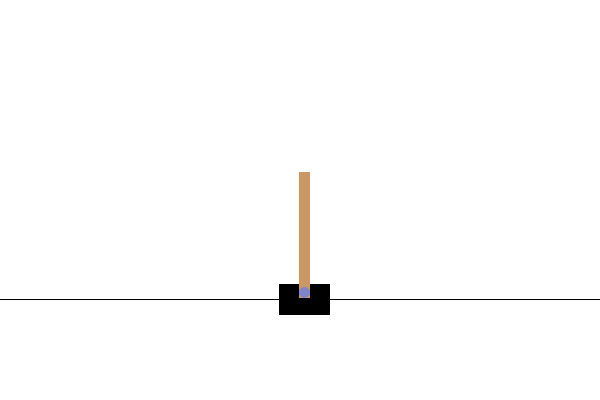

In [4]:
# Create the environment
env = gym.make('CartPole-v0', render_mode="rgb_array_list")
recorder = GymRecorder(env)

# Sample the initial state
state, info = env.reset()

# One episode:
done = False
return_episode = 0
while not done:

    # Select an action randomly
    action = env.action_space.sample()
    
    # Sample a single transition
    next_state, reward, terminal, truncated, info = env.step(action)

    # End of the episode
    done = terminal or truncated

    # Update undiscounted return
    return_episode += reward
    
    # Go in the next state
    state = next_state

print("Return:", return_episode)
recorder.record(env.render())

recorder.make_video("videos/cartpole_random.gif")

## Value network in pytorch

As the state in Cartpole has only four dimensions, we do not need a CNN for the value network. A simple MLP with a couple of hidden layers will be enough.

**Q:** Create a MLP class in pytorch taking four inputs and two outputs (one Q-value per action), and two hidden layers of 128 neurons (you can change it later). If possible, make it parameterizable, i.e. have the constructor take in the number of inputs, outputs and hidden neurons. The activation function for the hidden layers should be ReLU.

In [5]:
# Solution:
class MLP(torch.nn.Module):
    "Value network for DQN on Cartpole."

    def __init__(self, nb_observations, nb_hidden1, nb_hidden2, nb_actions):
        super(MLP, self).__init__()
        
        # Layers
        self.fc1 = torch.nn.Linear(nb_observations, nb_hidden1)
        self.fc2 = torch.nn.Linear(nb_hidden1, nb_hidden2)
        self.fc3 = torch.nn.Linear(nb_hidden2, nb_actions)

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

**Q:** Create a network, an environment, get the initial state using `env.reset()` and pass it to the network to obtain the Q-values.
Consider the following:
* the returned state from `env.reset()` is a NumPy array, but pytorch expects a tensor as input (usually with shape `(batch_size, num_features)`).
* Further, The dtype must be set to `torch.float32` for floating numbers (and `torch.long` for integers).
* Optionally, also add a batch dimension using `.unsqueeze(0)`.
* You can transform a NumPy array, as described, using the following command `nice_tensor = torch.tensor(<array>, dtype=torch.float32).unsqueeze(0)`.
* the network and data should be sent to the same device (see Pytorch exercise). You can use `.to(device)` to send them to the correct device. If you use `torch.tensor()` to create the tensor, you can also pass the device as argument: `torch.tensor(<array>, dtype=torch.float32, device=device)`.

Create the network using something like:

```python
net = MLP(...).to(device)
```

Pass the state tensor to your network. What is the shape of the output tensor?

In [6]:
# Solution:
# Create the environment
env = gym.make('CartPole-v0')

# Create the value network and send it to the correct device
net = MLP(env.observation_space.shape[0], 128, 128, env.action_space.n).to(device)

# Sample the initial state as a numpy array
state, info = env.reset()
print(state)

# Transform the state, send it to the device, and add a batch dimension
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

# Predict the Q-values from the initial state
Q_values = net(state)

print(state, state.shape)     # state as tensor
print(Q_values, Q_values.shape)  # Q-values for each action

[0.04458024 0.00889646 0.03967638 0.01768046]
tensor([[0.0446, 0.0089, 0.0397, 0.0177]]) torch.Size([1, 4])
tensor([[ 0.0429, -0.0247]], grad_fn=<AddmmBackward0>) torch.Size([1, 2])


The value network outputs one Q-value per action, great. Now, let's identify the **greedy** action, i.e. the one with the highest Q-value. The two actions expected by the cartpole environment are 0 and 1, i.e. the index of the element with the highest Q-value as a Python integer. 

Have a look at those two methods of `Tensor`:

* ``Tensor.argmax``: <https://pytorch.org/docs/stable/generated/torch.argmax.html>
* ``Tensor.item``: <https://pytorch.org/docs/stable/generated/torch.Tensor.item.html>

**Q:** Find a way to obtain the index (as a Python integer) of the element with the highest value in the tensor of Q-values. Check that it works. 

In [7]:
# Solution:
greedy_action = Q_values.argmax().item()
print(f"Greedy action: {greedy_action}")

Greedy action: 0


**Q:** Create a dummy agent class (as in the previous exercises) storing a value network and acting using $\epsilon$-greedy action selection. Add a ``test()``method running a few episodes and possibly recording them. 

The constructor should accept several hyperparameters, such as the `config` dictionary in the following skeleton:

```python
class RandomDQNAgent:
    def __init__(self, env, config):
    def act(self, state):
    def test(self, nb_episodes, recorder=None):
```

but feel free to pass the hyperparameters one by one.

To prepare ourselves, implement a schedule for `epsilon` in the `act()` method: epsilon should start at a high value of 0.9 and decrease exponentially to 0.05 for each action made. The value of epsilon follows this formula:

$$
    \epsilon = 0.05 + (0.9 - 0.05) * \exp ( - \dfrac{t}{1000})
$$

where t is the number of steps since the start. 0.05, 0.9 and 1000 should be parameters of the class.

In [8]:
# Solution:
class RandomDQNAgent:
    """
    Random deep Q-learning agent.
    """
    
    def __init__(self, env, config):

        self.env = env
        self.config = config
        self.epsilon = self.config['eps_start']

        # Number of actions
        self.n_actions = self.env.action_space.n

        # Number of states
        self.state, info = self.env.reset()
        self.n_observations = len(self.state)

        # Value network
        self.value_net = MLP(self.n_observations, config['nb_hidden'], config['nb_hidden'], self.n_actions).to(device)

        self.steps_done = 0
        
    
    def act(self, state):
        "Returns an action using epsilon-greedy action selection."

        # Decay epsilon exponentially
        self.epsilon = self.config['eps_end'] + (self.config['eps_start'] - self.config['eps_end']) * math.exp(-1. * self.steps_done / self.config['eps_decay'])

        # Keep track of time
        self.steps_done += 1
    
        # epsilon-greedy action selection
        if rng.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                return self.value_net(state).argmax().item()

    
    def test(self, nb_episodes, recorder=None):
        "Performs a test episode without exploration."
        previous_epsilon = self.epsilon
        self.epsilon = 0.0

        for episode in range(nb_episodes):
        
            # Reset
            state, _ = self.env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=device)

            # Sample the episode
            done = False
            return_episode = 0
            while not done:                
                action = self.act(state)
                next_state, reward, terminal, truncated, info = self.env.step(action)
                return_episode += reward
                done = terminal or truncated
                state = torch.tensor(next_state, dtype=torch.float32, device=device)

            print(f"Episode {episode}: return {return_episode}, epsilon: {self.epsilon:.4f}")
            
        self.epsilon = previous_epsilon
            
        if recorder is not None:
            recorder.record(self.env.render())


Episode 0: return 13.0, epsilon: 0.8899
Episode 1: return 31.0, epsilon: 0.8642
Episode 2: return 31.0, epsilon: 0.8394


Episode 3: return 67.0, epsilon: 0.7882
Episode 4: return 45.0, epsilon: 0.7557
Episode 5: return 13.0, epsilon: 0.7466
Episode 6: return 12.0, epsilon: 0.7383
Episode 7: return 15.0, epsilon: 0.7281


Episode 8: return 34.0, epsilon: 0.7054
Episode 9: return 19.0, epsilon: 0.6931
MoviePy - Building file videos/cartpole-random2.gif with imageio.


t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]

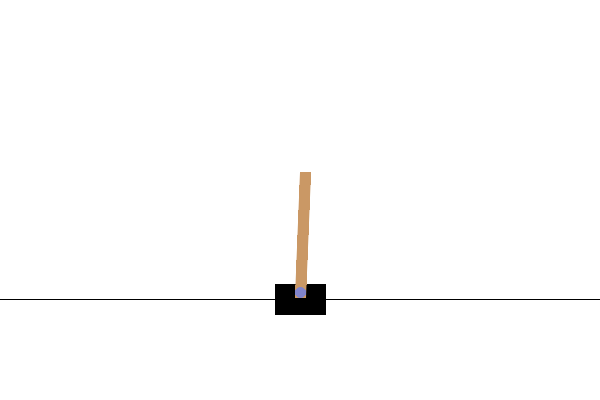

In [9]:
# Solution:
# Create the environment
env = gym.make('CartPole-v0', render_mode="rgb_array_list")
recorder = GymRecorder(env)

# Hyperparameters
config = {}
config['nb_hidden'] = 128 # number of hidden neurons in each layer
config['eps_start'] = 0.9 # starting value of epsilon
config['eps_end'] = 0.05 # final value of epsilon
config['eps_decay'] = 1000 # rate of exponential decay of epsilon, higher means a slower decay

# Create the agent
agent = RandomDQNAgent(env, config)

# Make 10 evaluation episodes
agent.test(10, recorder)

recorder.make_video("videos/cartpole-random2.gif")

## Target network

The original DQN algorithm implies two neural networks:

1. The value network $Q_\theta(s, a)$, learning to predict the Q-values for the current state.
2. The target network $Q_{\theta'}(s, a)$, used to predict the Q-values in the next state.

The target network is a copy of the value network (in terms of structure and parameters), but the update occurs only from time to time.

**Q:** Create two MLPs of the same size and predict the Q-values of a single state. What happens?

In [10]:
# Solution:
# Create the environment
env = gym.make('CartPole-v0')

# Create the value network
value_net = MLP(env.observation_space.shape[0], 128, 128, env.action_space.n).to(device)

# Create the target network
target_net = MLP(env.observation_space.shape[0], 128, 128, env.action_space.n).to(device)

# Sample the initial state
state, _ = env.reset()

# Cast the state to a tensor
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

# Predict the Q-values for both networks
Q_value = value_net(state)
Q_target = target_net(state)

print(Q_value, Q_value.shape)
print(Q_target, Q_target.shape)

tensor([[0.0835, 0.0332]], grad_fn=<AddmmBackward0>) torch.Size([1, 2])
tensor([[-0.0094, -0.0227]], grad_fn=<AddmmBackward0>) torch.Size([1, 2])


Obviously, the two MLPs are initialized using random parameters, so they are different. We need a method to copy the weights of a network into another one. 

It is fortunately very easy to save/load the parameters of a pytorch network:

```python
params = net.state_dict()
net.load_state_dict(params)
```

**Q:** Apply these methods to update the weights of the target network with the value one. Check that they now predict the same thing.

In [11]:
# Solution:
# Create the environment
env = gym.make('CartPole-v0')

# Create the value network
value_net = MLP(env.observation_space.shape[0], 128, 128, env.action_space.n).to(device)

# Create the target network
target_net = MLP(env.observation_space.shape[0], 128, 128, env.action_space.n).to(device)

# Update the target network
target_net.load_state_dict(value_net.state_dict())

# Sample the initial state
state, _ = env.reset()

# Cast the state to a tensor
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

# Predict the Q-values for both networks
Q_value = value_net(state)
Q_target = target_net(state)

print(Q_value, Q_value.shape)
print(Q_target, Q_target.shape)

tensor([[0.0575, 0.1468]], grad_fn=<AddmmBackward0>) torch.Size([1, 2])
tensor([[0.0575, 0.1468]], grad_fn=<AddmmBackward0>) torch.Size([1, 2])


## Experience Replay Memory

The second important component of DQN is the experience replay memory (ERM) or replay buffer. It is a limited size buffer that can store $(s, a, r, s', d)$ transitions, where $d$ is a boolean indicating whether the next state $s'$ is terminal or not (in gymnasium, this is the boolean `done = terminal or truncated`).

Below is a simple implementation of an ERM. The important data structure here is `deque` (double-ended queue) which behaves like a list when `append()` is called, until its capacity is reached (`maxlen`), in which case new elements overwrite older ones. 

`batch = sample(batch_size)` randomly samples a minibatch from the ERM and returns a structure of $(s, a, r, s', d)$ transitions, nicely casted into pytorch tensors. These tensors are accessed with `batch.state`, `batch.action`, etc.

In [12]:
# Named tuples are fancy dictionaries
Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'next_states', 'dones'))

class ReplayMemory(object):
    "Simple Experience Replay Memory using uniform sampling."

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def append(self, state, action, reward, next_state, done):
        "Appends a transition (s, a, r, s', done) to the buffer."

        # Get numpy arrays even if it is a torch tensor
        if isinstance(state, (torch.Tensor,)): state = state.numpy(force=True)
        if isinstance(next_state, (torch.Tensor,)): next_state = next_state.numpy(force=True)
        
        # Append to the buffer
        self.memory.append(Transition(state, action, reward, next_state, done))

    def sample(self, batch_size):
        "Returns a minibatch of (s, a, r, s', done)"

        # Sample the batch
        transitions = random.sample(self.memory, batch_size)
        
        # Transpose the batch.
        batch = Transition(*zip(*transitions))
        
        # Cast to tensors
        states = torch.tensor(batch.states, dtype=torch.float32, device=device)
        actions = torch.tensor(batch.actions, dtype=torch.long, device=device)
        rewards = torch.tensor(batch.rewards, dtype=torch.float32, device=device)
        next_states = torch.tensor(batch.next_states, dtype=torch.float32, device=device)
        dones = torch.tensor(batch.dones, dtype=torch.bool, device=device)

        return Transition(states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

**Q:** Modify your random DQN agent so that it stores a replay buffer of capacity 10000 and appends all transitions into it. Do a few episodes, sample a small minibatch and have a look at the data you obtain.

In [13]:
# Solution:
class RandomDQNAgent:
    """
    Random deep Q-learning agent with memory.
    """
    
    def __init__(self, env, config):

        self.env = env
        self.config = config
        self.epsilon = self.config['eps_start']

        # Number of actions
        self.n_actions = self.env.action_space.n

        # Number of states
        self.state, info = self.env.reset()
        self.n_observations = len(self.state)

        # Value network
        self.value_net = MLP(self.n_observations, config['nb_hidden'], config['nb_hidden'], self.n_actions).to(device)

        # Replay buffer
        self.memory = ReplayMemory(capacity=1000)

        self.steps_done = 0
        
    
    def act(self, state):
        "Returns an action using epsilon-greedy action selection."

        # Decay epsilon exponentially
        self.epsilon = self.config['eps_end'] + (self.config['eps_start'] - self.config['eps_end']) * math.exp(-1. * self.steps_done / self.config['eps_decay'])

        # Keep track of time
        self.steps_done += 1
    
        # epsilon-greedy action selection
        if rng.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                return self.value_net(state).argmax().item()

    
    def test(self, nb_episodes, recorder=None):
        "Performs a test episode without exploration."
        previous_epsilon = self.epsilon
        self.epsilon = 0.0

        for episode in range(nb_episodes):
        
            # Reset
            state, _ = self.env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=device)

            # Sample the episode
            done = False
            return_episode = 0
            while not done:                
                action = self.act(state)
                next_state, reward, terminal, truncated, info = self.env.step(action)
                return_episode += reward
                done = terminal or truncated
                
                # Append the transition to the replay buffer
                self.memory.append(state, action, reward, next_state, done)

                state = torch.tensor(next_state, dtype=torch.float32, device=device)

            print(f"Episode {episode}: return {return_episode}, epsilon: {self.epsilon:.4f}")
            
        self.epsilon = previous_epsilon
            
        if recorder is not None:
            recorder.record(self.env.render())


In [14]:
# Solution:
# Create the environment
env = gym.make('CartPole-v0')

# Hyperparameters
config = {}
config['nb_hidden'] = 128 # number of hidden neurons in each layer
config['eps_start'] = 0.9 # starting value of epsilon
config['eps_end'] = 0.05 # final value of epsilon
config['eps_decay'] = 1000 # rate of exponential decay of epsilon, higher means a slower decay
config['buffer_limit'] = 1000 # maximum number of transitions in the replay buffer

# Create the agent
agent = RandomDQNAgent(env, config)

# Make 10 evaluation episodes
agent.test(10)

Episode 0: return 28.0, epsilon: 0.8774
Episode 1: return 63.0, epsilon: 0.8268
Episode 2: return 17.0, epsilon: 0.8137
Episode 3: return 20.0, epsilon: 0.7986
Episode 4: return 19.0, epsilon: 0.7845
Episode 5: return 10.0, epsilon: 0.7772
Episode 6: return 10.0, epsilon: 0.7700
Episode 7: return 11.0, epsilon: 0.7621
Episode 8: return 16.0, epsilon: 0.7508
Episode 9: return 11.0, epsilon: 0.7431


In [15]:
# Solution:
# Sample the ERM
batch = agent.memory.sample(10)

print("States:", batch.states.shape, batch.states)
print("Actions:", batch.actions.shape, batch.actions)
print("Rewards:", batch.rewards.shape, batch.rewards)
print("Next states:", batch.next_states.shape, batch.next_states)
print("Dones:", batch.dones.shape, batch.dones)

States: torch.Size([10, 4]) tensor([[-9.8586e-03, -3.8289e-02,  1.1315e-02,  1.8353e-03],
        [-3.6510e-02,  6.0409e-01, -3.2505e-05, -8.4429e-01],
        [ 1.9189e-02,  5.2411e-01,  3.0443e-02, -3.6992e-01],
        [ 5.7185e-02,  9.9057e-01, -1.1136e-01, -1.4719e+00],
        [-3.2022e-02, -3.7651e-01,  6.0499e-03,  6.1092e-01],
        [-1.4347e-02,  4.0249e-01, -1.0342e-02, -5.2700e-01],
        [-2.3833e-02,  3.7676e-01, -2.8994e-02, -6.7214e-01],
        [ 2.8438e-02,  3.4300e-01,  2.0063e-02, -5.7591e-01],
        [-8.2391e-03, -3.8974e-02,  1.2031e-03,  1.6935e-02],
        [ 2.7020e-03,  5.7366e-01, -7.5808e-02, -1.0063e+00]])
Actions: torch.Size([10]) tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 1])
Rewards: torch.Size([10]) tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Next states: torch.Size([10, 4]) tensor([[-1.0624e-02,  1.5667e-01,  1.1352e-02, -2.8726e-01],
        [-2.4428e-02,  7.9921e-01, -1.6918e-02, -1.1370e+00],
        [ 2.9671e-02,  7.1879e-01,  2.3044e-02, -6.528

**Q:** Use the value network stored into your agent to predict the Q-values of all actions for the states contained in the minibatch. Do NOT use a for loop. Check the size of the resulting tensor. 

In [16]:
# Solution:
Q_values = agent.value_net(batch.states)

print(Q_values.shape)
print(Q_values)

torch.Size([10, 2])
tensor([[-0.1272,  0.0775],
        [-0.1431,  0.1396],
        [-0.1143,  0.1076],
        [-0.1751,  0.1723],
        [-0.1067,  0.0628],
        [-0.1303,  0.1189],
        [-0.1367,  0.1300],
        [-0.1324,  0.1158],
        [-0.1260,  0.0766],
        [-0.1541,  0.1479]], grad_fn=<AddmmBackward0>)


**Q:** The previous tensor returns the value of all actions in those visited states. We now want only the Q-value of action that was taken (whose index is in `batch.actions`). The resulting tensor should therefore a vector of length `batch_size`. How do we do that?

*Hint:* it would take months of practice to master all the indexing methods available in pytorch: <https://pytorch.org/docs/stable/torch.html#indexing-slicing-joining>. Meanwhile, numpy-style indexing could be useful. Check what the following statements do:

```python
N = 10
A = torch.randn((N, 2))
B = torch.randint(0, 2, (N,))
C = A[range(N), B]
```

In [17]:
# Solution:
print(Q_values)
print(batch.actions)
Q_taken = Q_values[range(10), batch.actions]
print(Q_taken)

tensor([[-0.1272,  0.0775],
        [-0.1431,  0.1396],
        [-0.1143,  0.1076],
        [-0.1751,  0.1723],
        [-0.1067,  0.0628],
        [-0.1303,  0.1189],
        [-0.1367,  0.1300],
        [-0.1324,  0.1158],
        [-0.1260,  0.0766],
        [-0.1541,  0.1479]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 1])
tensor([ 0.0775,  0.1396,  0.1076,  0.1723,  0.0628,  0.1189,  0.1300, -0.1324,
        -0.1260,  0.1479], grad_fn=<IndexBackward0>)


## DQN agent

Good, we should now have all the elementary bricks to create our DQN agent. 

Reminder from the lecture:

---

* Initialize value network $Q_{\theta}$ and target network $Q_{\theta'}$.

* Initialize experience replay memory $\mathcal{D}$ of maximal size $N$.

* for $t \in [0, T_\text{total}]$:

    * Select an action $a_t$ based on $Q_\theta(s_t, a)$ ($\epsilon$-greedy), observe $s_{t+1}$ and $r_{t+1}$.

    * Store $(s_t, a_t, r_{t+1}, s_{t+1})$ in the experience replay memory.

    * Every $T_\text{train}$ steps:

        * Sample a minibatch $\mathcal{D}_s$ randomly from $\mathcal{D}$.

        * For each transition $(s_k, a_k, r_k, s'_k)$ in the minibatch:

            * Compute the target value $t_k = r_k + \gamma \, \max_{a'} Q_{\theta'}(s'_k, a')$ using the target network.

        * Update the value network $Q_{\theta}$ on $\mathcal{D}_s$ to minimize:

    $$\mathcal{L}(\theta) = \mathbb{E}_{\mathcal{D}_s}[(t_k - Q_\theta(s_k, a_k))^2]$$

    * Every $T_\text{target}$ steps:

        * Update target network: $\theta' \leftarrow \theta$.
---

Create a DQN agent class inspired from the notebooks on MC or TD. The constructor should create the value and target networks, and make sure that their parameters are the same. It also creates an empty replay buffer. 

The `act()` method implements $\epsilon$-greedy action selection, with an exponentially decaying schedule for $\epsilon$. The greedy action is read from the value network.

The `train()` and `test()` methods run training and test episodes as usual, with optional rendering. The train method should return (or store in the object) the return of each episode (its length) so we can plot it at the end. 

The main difficulty will be the `update()` method, where learning is supposed to happen. It should sample a minibatch from the replay memory, compute a vector of Bellman targets $r_t + \gamma \, \max_a Q(s_{t+1}, a)$ for each transition in the batch, compute the loss function (mse between these targets and the predicted Q-values), backpropagate the gradients and apply the optimizer (Adam, but feel free to pick your preferred optimizer). Refer to the previous notebook on pytorch if you do not know how to do that.

The main tricky part is when $V(s_{t+1})$ has to be predicted by the **target** network. You do not want the target network to learn from the minibatch, so it should not compute the corresponding gradients to save computational time. You can make sure that the target network is purely in inference mode with the following context:

```python
with torch.no_grad():
    next_Q_values = target_net(batch.next_states)
```

Of course you want the Q-value of the greedy action in the next state, not the vector of all Q-values, so check the doc of `Tensor.max()`. 

Importantly, when the next state $s'$ is terminal (either the agent failed or the 200 steps are over), the Bellman target should be simply $r_t$ instead of $r_t + \gamma \, \max_a Q(s_{t+1}, a)$, as no action will be taken in the next state. This is why we saved the booleans `done` were saved in the replay buffer. As they are boolean, you can use them for indexing:

```python
Q = torch.randn((batch_size,))
Q[batch.dones] = 0.0
```

A minor detail: do not start learning until the replay buffer is full enough, otherwise you will not fill your minibatch. Usually, there is no learning until the buffer contains two or three times the batch size. Use `len(memory)` to know the current number of stored transitions.

Here is a set of suggested hyperparameters to help you start. Of course, it is strongly advised to modify them and observe their influence, but it depends on the remaining time.

* $\gamma = 0.99$.
* MLP with two layers of 128 neurons, Adam optimizer with a fixed learning rate of 0.001.
* Replay buffer of maximum capacity 10000, batch size of 128.
* Target network updated every 120 steps.
* Epsilon-greedy action selection, with the schedule:

$$
    \epsilon = 0.05 + (0.9 - 0.05) * \exp ( - \dfrac{t}{1000})
$$

where $t$ is the total number of steps.


**Q:** Train a DQN on cartpole for 250 episodes. How would you characterize the learning process (speed, stability, etc.). If possible, do several runs. Vary the hyperparameters.

In [18]:
# Solution:
class DQNAgent:
    "DQN agent."
    
    def __init__(self, env, config):

        # Parameters
        self.env = env
        self.config = config

        # Number of actions
        self.n_actions = self.env.action_space.n

        # Number of states
        self.state, info = self.env.reset()
        self.n_observations = len(self.state)

        # Value network
        self.value_net = MLP(self.n_observations, config['nb_hidden'], config['nb_hidden'], self.n_actions).to(device)

        # Target network
        self.target_net = MLP(self.n_observations, config['nb_hidden'], config['nb_hidden'], self.n_actions).to(device)

        # Copy the value weights into the target network
        self.target_net.load_state_dict(self.value_net.state_dict())

        # Optimizer
        self.optimizer = torch.optim.Adam(self.value_net.parameters(), lr=self.config['learning_rate'])

        # Loss function
        self.loss_function = torch.nn.MSELoss()
        
        # Replay buffer
        self.memory = ReplayMemory(self.config['buffer_limit'])

        self.steps_done = 0
        self.episode_durations = []


    def act(self, state):

        # Decay epsilon exponentially
        self.epsilon = self.config['eps_end'] + (self.config['eps_start'] - self.config['eps_end']) * math.exp(-1. * self.steps_done / self.config['eps_decay'])

        # Keep track of time
        self.steps_done += 1
    
        # epsilon-greedy action selection
        if rng.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                return self.value_net(state).argmax(dim=0).item()

    def update(self):

        # Only learn when the replay buffer is full enough
        if len(self.memory) < 2 * self.config['batch_size']:
            return
        
        # Sample a batch
        batch = self.memory.sample(self.config['batch_size'])

        # Compute Q(s_t, a) with the current value network.
        Q_values = self.value_net(batch.states)[range(self.config['batch_size']), batch.actions]
        
        # Compute Q(s_{t+1}, a*) for all next states.
        # If the next state is terminal, set the value to zero.
        # Do not compute gradients.
        with torch.no_grad():
            next_Q_values = self.target_net(batch.next_states).max(dim=1).values
            next_Q_values[batch.dones] = 0.0

        # Compute the target Q values
        targets = (next_Q_values * self.config['gamma']) + batch.rewards

        # Compute loss
        loss = self.loss_function(Q_values, targets)

        # Reinitialize the gradients
        self.optimizer.zero_grad()

        # Backpropagation
        loss.backward()

        # In-place gradient clipping (optional)
        #torch.nn.utils.clip_grad_value_(self.value_net.parameters(), 100)

        # Optimizer step
        self.optimizer.step()

    def train(self, num_episodes):
        
        for i_episode in range(num_episodes):

            tstart = time.time()

            # Initialize the environment and get its state
            state, _ = self.env.reset()

            # Transform the state into a tensor
            state = torch.tensor(state, dtype=torch.float32, device=device)

            done = False
            steps_episode = 0
            while not done:
                
                # Select an action
                action = self.act(state)
                
                # Perform the action
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                
                # Terminal state
                done = terminated or truncated

                # Store the transition in memory
                self.memory.append(state, action, reward, next_state, done)

                # Move to the next state
                state = torch.tensor(next_state, dtype=torch.float32, device=device)

                # Perform one step of the optimization (on the policy network)
                self.update()

                # Update of the target network's weights
                if self.steps_done % self.config['target_update_period'] == 0:
                    self.target_net.load_state_dict(self.value_net.state_dict())

                # Finish episode
                steps_episode += 1
                if done:
                    self.episode_durations.append(steps_episode)
                    print(f"Episode {i_episode+1}, duration {steps_episode}, epsilon {self.epsilon:.4f} done in {time.time() - tstart}")

In [19]:
# Solution:
# Hyperparameters
config = {}
config['nb_hidden'] = 128 # number of hidden neurons in each layer
config['batch_size'] = 128 # number of transitions sampled from the replay buffer
config['gamma'] = 0.99 # discount factor
config['eps_start'] = 0.9 # starting value of epsilon
config['eps_end'] = 0.05 # final value of epsilon
config['eps_decay'] = 1000 # rate of exponential decay of epsilon, higher means a slower decay
config['learning_rate'] = 1e-3 # learning rate of the optimizer
config['target_update_period'] = 120 # update period (in steps) of the target network
config['buffer_limit'] = 10000 # maximum number of transitions in the replay buffer

# Create the environment
env = gym.make('CartPole-v0')

# Create the agent
agent = DQNAgent(env, config)

# Train the agent
agent.train(num_episodes=250)


Episode 1, duration 13, epsilon 0.8899 done in 0.0013170242309570312
Episode 2, duration 27, epsilon 0.8675 done in 0.0019588470458984375
Episode 3, duration 38, epsilon 0.8370 done in 0.0021452903747558594
Episode 4, duration 21, epsilon 0.8207 done in 0.0017828941345214844
Episode 5, duration 13, epsilon 0.8107 done in 0.0007145404815673828
Episode 6, duration 16, epsilon 0.7986 done in 0.0011048316955566406
Episode 7, duration 12, epsilon 0.7897 done in 0.0006771087646484375
Episode 8, duration 15, epsilon 0.7787 done in 0.0008466243743896484
Episode 9, duration 17, epsilon 0.7664 done in 0.0011718273162841797
Episode 10, duration 16, epsilon 0.7550 done in 0.0011196136474609375
Episode 11, duration 13, epsilon 0.7459 done in 0.0009295940399169922
Episode 12, duration 13, epsilon 0.7369 done in 0.0008358955383300781
Episode 13, duration 18, epsilon 0.7247 done in 0.000995635986328125
Episode 14, duration 10, epsilon 0.7180 done in 0.0008766651153564453
Episode 15, duration 31, epsil

Episode 18, duration 57, epsilon 0.6407 done in 0.10212945938110352
Episode 19, duration 29, epsilon 0.6238 done in 0.05161166191101074
Episode 20, duration 11, epsilon 0.6175 done in 0.019373655319213867
Episode 21, duration 11, epsilon 0.6113 done in 0.019716739654541016
Episode 22, duration 18, epsilon 0.6013 done in 0.03245139122009277
Episode 23, duration 35, epsilon 0.5823 done in 0.0624234676361084


Episode 24, duration 10, epsilon 0.5770 done in 0.01868915557861328
Episode 25, duration 10, epsilon 0.5718 done in 0.01819610595703125
Episode 26, duration 10, epsilon 0.5666 done in 0.017847776412963867
Episode 27, duration 12, epsilon 0.5604 done in 0.02120065689086914
Episode 28, duration 21, epsilon 0.5498 done in 0.03752899169921875
Episode 29, duration 11, epsilon 0.5443 done in 0.019932031631469727
Episode 30, duration 13, epsilon 0.5380 done in 0.0235135555267334
Episode 31, duration 18, epsilon 0.5293 done in 0.03266000747680664
Episode 32, duration 15, epsilon 0.5221 done in 0.02704334259033203


Episode 33, duration 16, epsilon 0.5146 done in 0.030436277389526367
Episode 34, duration 19, epsilon 0.5059 done in 0.03438448905944824
Episode 35, duration 56, epsilon 0.4811 done in 0.10079741477966309
Episode 36, duration 16, epsilon 0.4742 done in 0.028832674026489258


Episode 37, duration 49, epsilon 0.4539 done in 0.09007620811462402
Episode 38, duration 19, epsilon 0.4463 done in 0.034131526947021484
Episode 39, duration 18, epsilon 0.4393 done in 0.03288698196411133


Episode 40, duration 118, epsilon 0.3959 done in 0.21999073028564453
Episode 41, duration 46, epsilon 0.3804 done in 0.08459281921386719


Episode 42, duration 140, epsilon 0.3372 done in 0.25904059410095215


Episode 43, duration 200, epsilon 0.2852 done in 0.3726358413696289
Episode 44, duration 48, epsilon 0.2741 done in 0.09080076217651367


Episode 45, duration 200, epsilon 0.2335 done in 0.38110780715942383


Episode 46, duration 200, epsilon 0.2002 done in 0.3801577091217041


Episode 47, duration 200, epsilon 0.1730 done in 0.3795149326324463


Episode 48, duration 200, epsilon 0.1507 done in 0.38080549240112305


Episode 49, duration 155, epsilon 0.1362 done in 0.29812002182006836


Episode 50, duration 200, epsilon 0.1206 done in 0.38503050804138184


Episode 51, duration 200, epsilon 0.1078 done in 0.3858003616333008


Episode 52, duration 200, epsilon 0.0973 done in 0.38599395751953125


Episode 53, duration 200, epsilon 0.0888 done in 0.3857438564300537


Episode 54, duration 200, epsilon 0.0817 done in 0.38429737091064453


Episode 55, duration 200, epsilon 0.0760 done in 0.38439416885375977


Episode 56, duration 200, epsilon 0.0713 done in 0.38088083267211914


Episode 57, duration 200, epsilon 0.0674 done in 0.3798694610595703


Episode 58, duration 200, epsilon 0.0643 done in 0.37824225425720215


Episode 59, duration 200, epsilon 0.0617 done in 0.38077759742736816


Episode 60, duration 200, epsilon 0.0596 done in 0.37789034843444824


Episode 61, duration 200, epsilon 0.0578 done in 0.38310718536376953


Episode 62, duration 200, epsilon 0.0564 done in 0.3843722343444824


Episode 63, duration 200, epsilon 0.0552 done in 0.38727331161499023


Episode 64, duration 200, epsilon 0.0543 done in 0.38492250442504883


Episode 65, duration 200, epsilon 0.0535 done in 0.38335680961608887


Episode 66, duration 200, epsilon 0.0529 done in 0.38243556022644043


Episode 67, duration 200, epsilon 0.0524 done in 0.3821873664855957


Episode 68, duration 200, epsilon 0.0519 done in 0.3803079128265381


Episode 69, duration 198, epsilon 0.0516 done in 0.380230188369751


Episode 70, duration 192, epsilon 0.0513 done in 0.36708855628967285


Episode 71, duration 169, epsilon 0.0511 done in 0.32491540908813477


Episode 72, duration 200, epsilon 0.0509 done in 0.37996888160705566


Episode 73, duration 200, epsilon 0.0507 done in 0.3820931911468506


Episode 74, duration 200, epsilon 0.0506 done in 0.3837888240814209


Episode 75, duration 200, epsilon 0.0505 done in 0.38320207595825195


Episode 76, duration 166, epsilon 0.0504 done in 0.31711483001708984


Episode 77, duration 200, epsilon 0.0503 done in 0.38184332847595215


Episode 78, duration 198, epsilon 0.0503 done in 0.38053226470947266


Episode 79, duration 200, epsilon 0.0502 done in 0.3853156566619873


Episode 80, duration 173, epsilon 0.0502 done in 0.3328063488006592


Episode 81, duration 158, epsilon 0.0502 done in 0.3044438362121582


Episode 82, duration 125, epsilon 0.0501 done in 0.24444937705993652


Episode 83, duration 200, epsilon 0.0501 done in 0.38819026947021484


Episode 84, duration 191, epsilon 0.0501 done in 0.3688945770263672


Episode 85, duration 200, epsilon 0.0501 done in 0.390458345413208


Episode 86, duration 200, epsilon 0.0501 done in 0.3853132724761963


Episode 87, duration 200, epsilon 0.0501 done in 0.3821296691894531


Episode 88, duration 177, epsilon 0.0500 done in 0.33750152587890625


Episode 89, duration 139, epsilon 0.0500 done in 0.26654887199401855


Episode 90, duration 168, epsilon 0.0500 done in 0.3221626281738281


Episode 91, duration 134, epsilon 0.0500 done in 0.2555668354034424


Episode 92, duration 200, epsilon 0.0500 done in 0.38726353645324707


Episode 93, duration 200, epsilon 0.0500 done in 0.38982319831848145


Episode 94, duration 200, epsilon 0.0500 done in 0.3906879425048828


Episode 95, duration 200, epsilon 0.0500 done in 0.3895263671875


Episode 96, duration 138, epsilon 0.0500 done in 0.26951098442077637


Episode 97, duration 196, epsilon 0.0500 done in 0.3836839199066162


Episode 98, duration 200, epsilon 0.0500 done in 0.38889575004577637


Episode 99, duration 200, epsilon 0.0500 done in 0.3820459842681885


Episode 100, duration 172, epsilon 0.0500 done in 0.3291196823120117


Episode 101, duration 188, epsilon 0.0500 done in 0.35816049575805664


Episode 102, duration 200, epsilon 0.0500 done in 0.3847804069519043


Episode 103, duration 200, epsilon 0.0500 done in 0.38524508476257324


Episode 104, duration 167, epsilon 0.0500 done in 0.3230247497558594


Episode 105, duration 175, epsilon 0.0500 done in 0.33301639556884766


Episode 106, duration 177, epsilon 0.0500 done in 0.3395555019378662


Episode 107, duration 200, epsilon 0.0500 done in 0.38375353813171387


Episode 108, duration 200, epsilon 0.0500 done in 0.38458752632141113


Episode 109, duration 150, epsilon 0.0500 done in 0.28746604919433594


Episode 110, duration 155, epsilon 0.0500 done in 0.29691314697265625


Episode 111, duration 185, epsilon 0.0500 done in 0.3539576530456543


Episode 112, duration 200, epsilon 0.0500 done in 0.38202381134033203


Episode 113, duration 200, epsilon 0.0500 done in 0.38637256622314453


Episode 114, duration 199, epsilon 0.0500 done in 0.3841431140899658


Episode 115, duration 200, epsilon 0.0500 done in 0.3852872848510742


Episode 116, duration 200, epsilon 0.0500 done in 0.385545015335083


Episode 117, duration 200, epsilon 0.0500 done in 0.3874051570892334


Episode 118, duration 200, epsilon 0.0500 done in 0.3850572109222412


Episode 119, duration 200, epsilon 0.0500 done in 0.3863818645477295


Episode 120, duration 200, epsilon 0.0500 done in 0.3841242790222168


Episode 121, duration 183, epsilon 0.0500 done in 0.376631498336792


Episode 122, duration 171, epsilon 0.0500 done in 0.32819557189941406


Episode 123, duration 162, epsilon 0.0500 done in 0.31400156021118164


Episode 124, duration 175, epsilon 0.0500 done in 0.33802032470703125


Episode 125, duration 200, epsilon 0.0500 done in 0.3831450939178467


Episode 126, duration 200, epsilon 0.0500 done in 0.385251522064209


Episode 127, duration 200, epsilon 0.0500 done in 0.38918638229370117


Episode 128, duration 200, epsilon 0.0500 done in 0.3941948413848877


Episode 129, duration 200, epsilon 0.0500 done in 0.39388227462768555


Episode 130, duration 200, epsilon 0.0500 done in 0.3911886215209961


Episode 131, duration 173, epsilon 0.0500 done in 0.3413839340209961


Episode 132, duration 200, epsilon 0.0500 done in 0.39034485816955566


Episode 133, duration 200, epsilon 0.0500 done in 0.3805687427520752


Episode 134, duration 200, epsilon 0.0500 done in 0.3852267265319824


Episode 135, duration 195, epsilon 0.0500 done in 0.37619733810424805


Episode 136, duration 200, epsilon 0.0500 done in 0.38608288764953613


Episode 137, duration 200, epsilon 0.0500 done in 0.3868584632873535


Episode 138, duration 200, epsilon 0.0500 done in 0.3930373191833496


Episode 139, duration 200, epsilon 0.0500 done in 0.39281225204467773


Episode 140, duration 200, epsilon 0.0500 done in 0.39017486572265625


Episode 141, duration 200, epsilon 0.0500 done in 0.3909025192260742


Episode 142, duration 200, epsilon 0.0500 done in 0.39044713973999023


Episode 143, duration 200, epsilon 0.0500 done in 0.38634371757507324


Episode 144, duration 200, epsilon 0.0500 done in 0.3867206573486328


Episode 145, duration 200, epsilon 0.0500 done in 0.3860793113708496


Episode 146, duration 200, epsilon 0.0500 done in 0.392336368560791


Episode 147, duration 200, epsilon 0.0500 done in 0.39420151710510254
Episode 148, duration 97, epsilon 0.0500 done in 0.18929290771484375


Episode 149, duration 121, epsilon 0.0500 done in 0.23312854766845703


Episode 150, duration 200, epsilon 0.0500 done in 0.3852701187133789


Episode 151, duration 200, epsilon 0.0500 done in 0.39148497581481934


Episode 152, duration 200, epsilon 0.0500 done in 0.39302515983581543


Episode 153, duration 200, epsilon 0.0500 done in 0.39451169967651367


Episode 154, duration 200, epsilon 0.0500 done in 0.3950817584991455


Episode 155, duration 200, epsilon 0.0500 done in 0.39293527603149414


Episode 156, duration 200, epsilon 0.0500 done in 0.38477063179016113


Episode 157, duration 200, epsilon 0.0500 done in 0.38483119010925293


Episode 158, duration 200, epsilon 0.0500 done in 0.4198131561279297


Episode 159, duration 200, epsilon 0.0500 done in 0.38835740089416504


Episode 160, duration 200, epsilon 0.0500 done in 0.3892030715942383


Episode 161, duration 200, epsilon 0.0500 done in 0.3873608112335205


Episode 162, duration 200, epsilon 0.0500 done in 0.38774633407592773


Episode 163, duration 200, epsilon 0.0500 done in 0.3914494514465332


Episode 164, duration 200, epsilon 0.0500 done in 0.397411584854126


Episode 165, duration 200, epsilon 0.0500 done in 0.3895390033721924


Episode 166, duration 200, epsilon 0.0500 done in 0.390012264251709


Episode 167, duration 200, epsilon 0.0500 done in 0.3915238380432129


Episode 168, duration 200, epsilon 0.0500 done in 0.3908569812774658


Episode 169, duration 200, epsilon 0.0500 done in 0.38950133323669434


Episode 170, duration 200, epsilon 0.0500 done in 0.387218713760376


Episode 171, duration 200, epsilon 0.0500 done in 0.3891184329986572


Episode 172, duration 200, epsilon 0.0500 done in 0.389218807220459


Episode 173, duration 200, epsilon 0.0500 done in 0.388521671295166


Episode 174, duration 200, epsilon 0.0500 done in 0.3918616771697998


Episode 175, duration 200, epsilon 0.0500 done in 0.3959934711456299


Episode 176, duration 161, epsilon 0.0500 done in 0.3165163993835449


Episode 177, duration 183, epsilon 0.0500 done in 0.35698580741882324


Episode 178, duration 200, epsilon 0.0500 done in 0.38718175888061523


Episode 179, duration 186, epsilon 0.0500 done in 0.3609194755554199


Episode 180, duration 200, epsilon 0.0500 done in 0.39847683906555176


Episode 181, duration 200, epsilon 0.0500 done in 0.3897705078125


Episode 182, duration 200, epsilon 0.0500 done in 0.3804938793182373


Episode 183, duration 184, epsilon 0.0500 done in 0.3559856414794922


Episode 184, duration 157, epsilon 0.0500 done in 0.30185842514038086


Episode 185, duration 180, epsilon 0.0500 done in 0.3464791774749756


Episode 186, duration 183, epsilon 0.0500 done in 0.3503403663635254


Episode 187, duration 164, epsilon 0.0500 done in 0.31424927711486816


Episode 188, duration 185, epsilon 0.0500 done in 0.35315728187561035


Episode 189, duration 187, epsilon 0.0500 done in 0.36301493644714355


Episode 190, duration 167, epsilon 0.0500 done in 0.32218360900878906


Episode 191, duration 179, epsilon 0.0500 done in 0.3466200828552246


Episode 192, duration 180, epsilon 0.0500 done in 0.34498095512390137


Episode 193, duration 154, epsilon 0.0500 done in 0.29302310943603516


Episode 194, duration 198, epsilon 0.0500 done in 0.3739199638366699


Episode 195, duration 190, epsilon 0.0500 done in 0.3635556697845459


Episode 196, duration 197, epsilon 0.0500 done in 0.38211774826049805


Episode 197, duration 176, epsilon 0.0500 done in 0.33568406105041504


Episode 198, duration 200, epsilon 0.0500 done in 0.3844780921936035


Episode 199, duration 191, epsilon 0.0500 done in 0.36528801918029785


Episode 200, duration 200, epsilon 0.0500 done in 0.3844931125640869


Episode 201, duration 196, epsilon 0.0500 done in 0.37690305709838867


Episode 202, duration 192, epsilon 0.0500 done in 0.36079931259155273


Episode 203, duration 200, epsilon 0.0500 done in 0.38136982917785645


Episode 204, duration 200, epsilon 0.0500 done in 0.3799614906311035


Episode 205, duration 200, epsilon 0.0500 done in 0.38332271575927734


Episode 206, duration 200, epsilon 0.0500 done in 0.38199353218078613


Episode 207, duration 200, epsilon 0.0500 done in 0.3779923915863037


Episode 208, duration 200, epsilon 0.0500 done in 0.3795664310455322


Episode 209, duration 200, epsilon 0.0500 done in 0.3854529857635498


Episode 210, duration 200, epsilon 0.0500 done in 0.38541460037231445


Episode 211, duration 200, epsilon 0.0500 done in 0.3877737522125244


Episode 212, duration 200, epsilon 0.0500 done in 0.3894350528717041


Episode 213, duration 200, epsilon 0.0500 done in 0.38631439208984375


Episode 214, duration 196, epsilon 0.0500 done in 0.3709261417388916


Episode 215, duration 165, epsilon 0.0500 done in 0.3144803047180176


Episode 216, duration 200, epsilon 0.0500 done in 0.38432812690734863


Episode 217, duration 163, epsilon 0.0500 done in 0.3067433834075928


Episode 218, duration 175, epsilon 0.0500 done in 0.3331446647644043


Episode 219, duration 200, epsilon 0.0500 done in 0.3797111511230469


Episode 220, duration 200, epsilon 0.0500 done in 0.3830595016479492


Episode 221, duration 200, epsilon 0.0500 done in 0.38390588760375977


Episode 222, duration 200, epsilon 0.0500 done in 0.3807399272918701


Episode 223, duration 200, epsilon 0.0500 done in 0.3896608352661133


Episode 224, duration 200, epsilon 0.0500 done in 0.39298486709594727


Episode 225, duration 200, epsilon 0.0500 done in 0.39144277572631836


Episode 226, duration 200, epsilon 0.0500 done in 0.39231204986572266


Episode 227, duration 200, epsilon 0.0500 done in 0.38721370697021484


Episode 228, duration 200, epsilon 0.0500 done in 0.39058923721313477


Episode 229, duration 200, epsilon 0.0500 done in 0.38837599754333496


Episode 230, duration 200, epsilon 0.0500 done in 0.38698339462280273


Episode 231, duration 138, epsilon 0.0500 done in 0.26784777641296387


Episode 232, duration 200, epsilon 0.0500 done in 0.3849947452545166


Episode 233, duration 200, epsilon 0.0500 done in 0.3861227035522461


Episode 234, duration 144, epsilon 0.0500 done in 0.27577853202819824


Episode 235, duration 200, epsilon 0.0500 done in 0.3782308101654053


Episode 236, duration 200, epsilon 0.0500 done in 0.3834395408630371


Episode 237, duration 121, epsilon 0.0500 done in 0.23222589492797852


Episode 238, duration 110, epsilon 0.0500 done in 0.2086772918701172


Episode 239, duration 139, epsilon 0.0500 done in 0.2625553607940674


Episode 240, duration 119, epsilon 0.0500 done in 0.2230818271636963


Episode 241, duration 133, epsilon 0.0500 done in 0.2537405490875244


Episode 242, duration 142, epsilon 0.0500 done in 0.27371716499328613


Episode 243, duration 124, epsilon 0.0500 done in 0.23917317390441895


Episode 244, duration 129, epsilon 0.0500 done in 0.24872469902038574


Episode 245, duration 120, epsilon 0.0500 done in 0.2313532829284668


Episode 246, duration 200, epsilon 0.0500 done in 0.3811676502227783


Episode 247, duration 143, epsilon 0.0500 done in 0.272219181060791


Episode 248, duration 131, epsilon 0.0500 done in 0.24968290328979492


Episode 249, duration 118, epsilon 0.0500 done in 0.23028898239135742


Episode 250, duration 130, epsilon 0.0500 done in 0.24931979179382324


Text(0, 0.5, 'Returns')

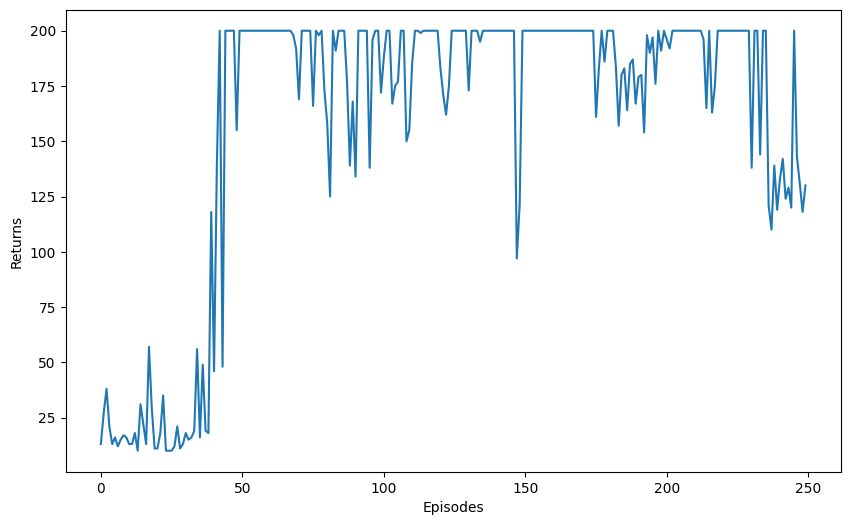

In [20]:
# Solution:
plt.figure(figsize=(10, 6))
plt.plot(agent.episode_durations)
plt.xlabel("Episodes")
plt.ylabel("Returns")

**A:** Training is very slow and unstable. Different runs lead to very different convergence profiles. There is much to improve...